In [3]:
import numpy as np
import pandas as pd

#데이터 불러오기
input_file = 'stocks_2000_2020_data_by_sector.xlsx'

all_price = []

# Excel 파일에 저장된 모든 시트 이름으로 불러오기
xls = pd.ExcelFile(input_file)
sheet_names = xls.sheet_names

# 모든 시트의 데이터를 하나의 데이터프레임으로 합치기
all_data = pd.concat([pd.read_excel(input_file, sheet_name=sheet, index_col=0) for sheet in sheet_names], axis=1)

# 날짜별 55개 주가데이터를 하나의 array로 형성
price_55 = all_data.values

# 로그 수익률 계산
log_returns_55 = np.log(price_55) - np.log(np.roll(price_55, 1, axis=0))

# 첫 번째 행은 이전 값이 없으므로 NaN이 됩니다. 이를 제거합니다.
log_returns_55 = log_returns_55[1:]

# 결과 확인
print(log_returns_55)

[[-0.03285929  0.05692597 -0.06029216 ... -0.00102407 -0.01589859
   0.        ]
 [ 0.03285929  0.04066387  0.01541715 ... -0.01444814 -0.0129034
   0.00820798]
 [-0.01153653 -0.04066387 -0.02678092 ... -0.03598272  0.0192932
   0.03743753]
 ...
 [ 0.00237651  0.02910104 -0.00489169 ...  0.01450469  0.01002774
   0.00126637]
 [-0.00288648 -0.00876015 -0.00035033 ... -0.00281999 -0.00510361
  -0.0058651 ]
 [-0.01145805  0.02159258 -0.00175345 ...  0.00371558  0.01119376
   0.00494819]]


In [11]:
#10일씩 데이터 분리하여 사용 데이터 프레임 구성
window_size = 60

data_X = []
data_y = []
for i in range(len(log_returns_55) - window_size):
    _X = log_returns_55[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = log_returns_55[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)

In [12]:
#학습데이터와 테스트데이터 셋 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (3655, 60, 55) (3655, 55)
테스트 데이터의 크기 : (1567, 60, 55) (1567, 55)


In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.initializers import RandomNormal

# 가중치 초기화 방법 설정
init = RandomNormal(mean=0., stddev=0.5)

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(60, 55), kernel_initializer=init))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu', kernel_initializer=init))
model.add(Dropout(0.1))
model.add(Dense(units=55, kernel_initializer=init))
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 20)            6080      
                                                                 
 dropout_6 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 55)                1155      
                                                                 
Total params: 10515 (41.07 KB)
Trainable params: 10515 (41.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# 옵티마이저와 손실함수 결정 및 학습 실행
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=80, batch_size=64)

Epoch 1/80
58/58 [==============================] - 5s 44ms/step - loss: 0.0049
Epoch 2/80
58/58 [==============================] - 4s 65ms/step - loss: 0.0010
Epoch 3/80
58/58 [==============================] - 3s 51ms/step - loss: 7.6076e-04
Epoch 4/80
58/58 [==============================] - 3s 44ms/step - loss: 6.4982e-04
Epoch 5/80
58/58 [==============================] - 3s 44ms/step - loss: 5.8124e-04
Epoch 6/80
58/58 [==============================] - 3s 44ms/step - loss: 5.3923e-04
Epoch 7/80
58/58 [==============================] - 5s 80ms/step - loss: 5.1877e-04
Epoch 8/80
58/58 [==============================] - 3s 44ms/step - loss: 5.0134e-04
Epoch 9/80
58/58 [==============================] - 3s 45ms/step - loss: 4.9365e-04
Epoch 10/80
58/58 [==============================] - 3s 44ms/step - loss: 4.8646e-04
Epoch 11/80
58/58 [==============================] - 3s 54ms/step - loss: 4.8588e-04
Epoch 12/80
58/58 [==============================] - 4s 63ms/step - loss: 4.8148e-

In [ ]:
#가중치 저장
model.save_weights('LSTM_55stocks_prd_weight.h5')

In [33]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }

# 예측 결과 얻기
pred_y = model.predict(test_X)

# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20

# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    # plt.plot(test_y[:,i], color='blue', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(pred_y[:,i], color='red', label='Predicted Stock Price of ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [34]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([test_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='blue', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_y = np.mean([pred_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price of ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

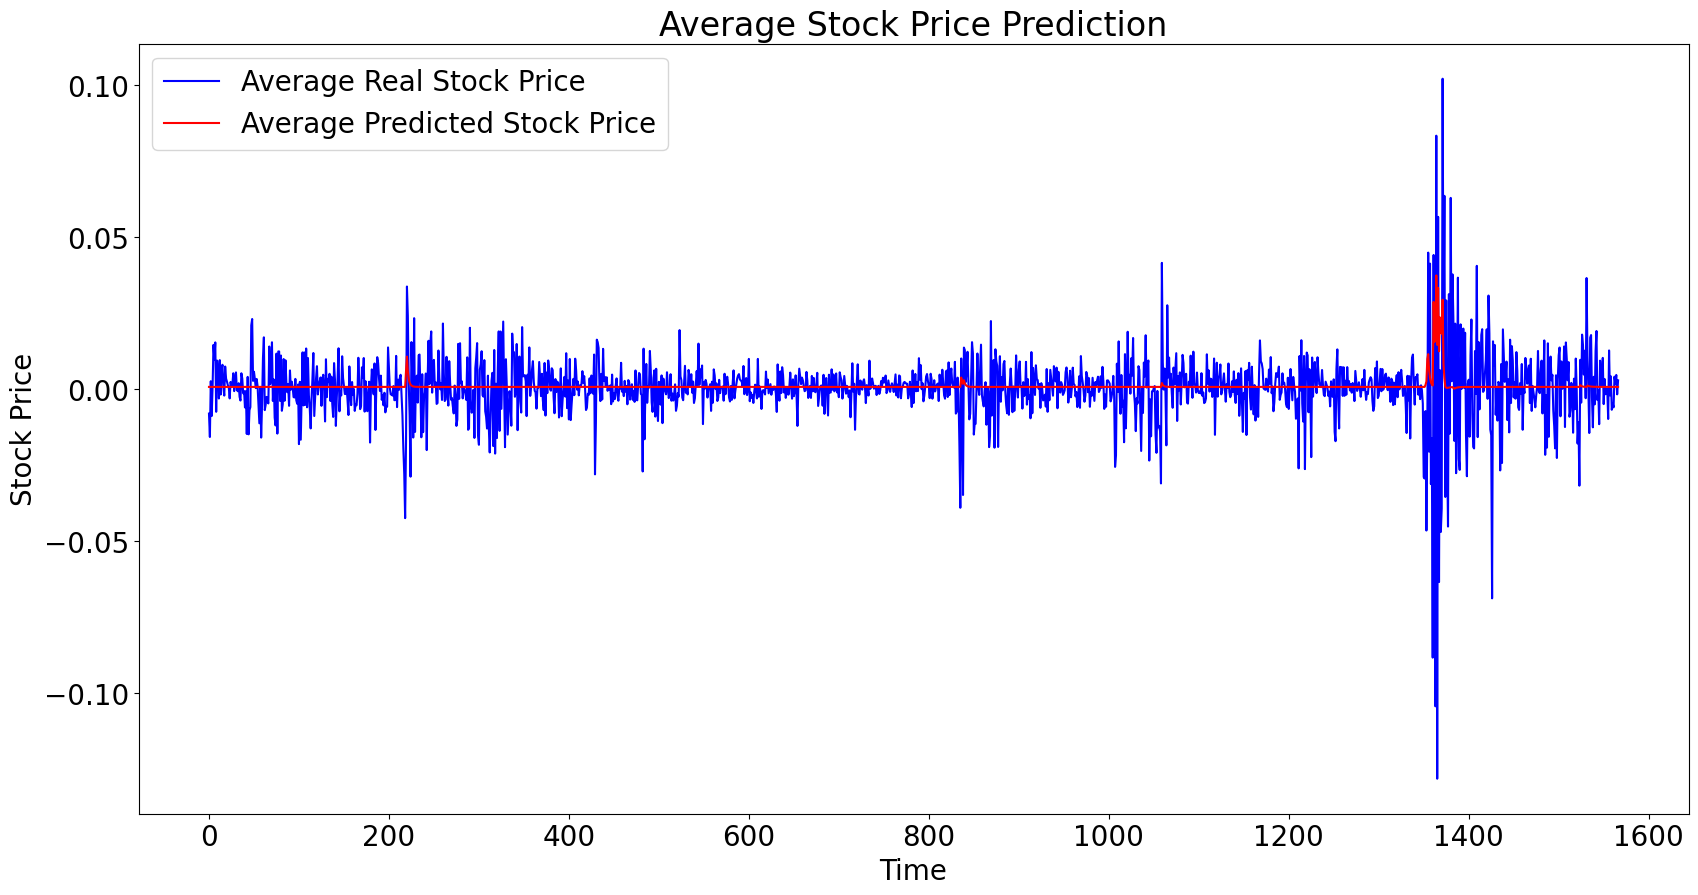

In [38]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(test_y, axis=1)
plt.plot(avg_test_y, color='blue', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_y = np.mean(pred_y, axis=1)
plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price')

plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
